In [746]:
# The code was removed by Watson Studio for sharing.

<h1>Capstone Project - Battle of Neighborhoods (week 2)</h1>
<h2>Applied Data Science Capstone</h2>

<h3>Introduction to Business Problem</h3>

<h4>Opening a new Italian Restaurant in Bangalore, Karnataka</h4>

<t>The objective of this report is to determine the best possible location to open an Italian Restaurant in Bangalore, Karnataka based on the different localities of the city, already established Italian restaurant in varios geographical location and ease of accessibility by maximum number of people so that the revenue from the latest venture can be maximized.</t>

<h3>Data</h3>

<t>This project will use data from : </t>
<ul>
    <li>Geopy - For getting the co-ordinated of different locations.</li>
    <li>Foursquare API - To get the list of vanues and their details around a given location.</li>
</ul>

<h3>Methodology</h3>

<ol>
    <li>Getting the co-ordinates of the target city.</li>
    <li>Getting the list of neighborhoods and their co-ordinates.</li>
    <li>Exploring the most visited venues in the target localities.</li>
    <li>Clustering the localities.</li>
    <li>Analyzing the clusters formed.</li>
    <li>Collecting information about the type of restaurants already present in a locality.</li>
    <li>Creating a machine learning model based on data acquired.</li>
    <li>Using the model to predict the locality best suited for upcoming Italian Resataurant.</li>
</ol>

<h3>1. Importing required libraries</h3>

In [747]:
#Importing required libraries
import numpy as np
import pandas as pd

from geopy.geocoders import Nominatim
try:
    import geocoder
except:
    !pip install geocoder
    import geocoder

import requests
from bs4 import BeautifulSoup

try:
    import folium
except:
    !pip install folium
    import folium
    
from sklearn.cluster import KMeans

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

import matplotlib.pyplot as plt

<h3>2. Getting the location</h3>

In [748]:
#Getting the location of Bangalore city using the geocoder package
g = geocoder.arcgis('Bangalore, India')
blr_lat = g.latlng[0]
blr_lng = g.latlng[1]
print("The Latitude and Longitude of Bangalore is {} and {}".format(blr_lat, blr_lng))

The Latitude and Longitude of Bangalore is 12.966180000000065 and 77.58690000000007


<h3>3. Getting the List of Neighborhoods in Bangalore from Wikipedia</h3>

In [749]:
#Scraping the Wikimedia webpage for list of localities present in Bangalore city
neig = requests.get("https://commons.wikimedia.org/wiki/Category:Suburbs_of_Bangalore").text

In [750]:
#parsing the scraped content
soup = BeautifulSoup(neig, 'html.parser')

In [751]:
#Creating a list to store neighborhood data
neighborhoodlist = []

In [752]:
#Searching the localities using class labels and appending it to the neighborhood list
for i in soup.find_all('div', class_='mw-category')[0].find_all('a'):
    neighborhoodlist.append(i.text)

#Creating a dataframe from the list
neig_df = pd.DataFrame({"Locality": neighborhoodlist})
neig_df.head()

,Locality
0,"Agara, Bangalore"
1,Arekere
2,Banashankari
3,Banaswadi
4,Basavanagudi


In [753]:
#Shape of dataframe neig_df
neig_df.shape

(59, 1)

<h3>4. Getting the location of the Localities</h3>

In [754]:
#Defining a function to get the location of the localities
def get_location(localities):
    g = geocoder.arcgis('{}, Bangalore, India'.format(localities))
    get_latlng = g.latlng
    return get_latlng

In [755]:
#Creating an empty list
co_ordinates = []
#Getting the co-ordinates of each locality using the function defined above
for i in neig_df["Locality"].tolist():
    co_ordinates.append(get_location(i))
print(co_ordinates)

[[12.842830000000049, 77.48759000000007], [12.885680000000036, 77.59668000000005], [12.922310000000039, 77.56988000000007], [13.028477106077231, 77.63188968370176], [12.938980000000072, 77.57137000000006], [12.882450000000063, 77.62475000000006], [12.927350000000047, 77.67185000000006], [12.975753300305838, 77.6162602769923], [12.960530000000063, 77.64385000000004], [12.966180000000065, 77.58690000000007], [12.817530000000033, 77.67879000000005], [12.966235877087087, 77.6067910877087], [12.794010000000071, 77.70015000000006], [12.96679000000006, 77.63346000000007], [12.966180000000065, 77.58690000000007], [12.943290000000047, 77.65602000000007], [12.845470000000034, 77.66430000000008], [12.998940000000061, 77.61276000000004], [12.942790000000059, 77.54122000000007], [13.02642000000003, 77.62437000000006], [13.049810000000036, 77.58903000000004], [13.077180000000055, 77.80178000000006], [12.912160000000029, 77.64490000000006], [12.973940000000027, 77.64390000000003], [12.923440000000028

In [756]:
#Creating a dataframe from the list of location co-ordinates
co_ordinates_df = pd.DataFrame(co_ordinates, columns=['Latitudes', 'Longitudes'])

In [757]:
#Adding co-ordinates of localities to neig_df dataframe
neig_df["Latitudes"] = co_ordinates_df["Latitudes"]
neig_df["Longitudes"] = co_ordinates_df["Longitudes"]

In [758]:
print("The shape of neig_df is {}".format(neig_df.shape))
neig_df.head()

The shape of neig_df is (59, 3)


,Locality,Latitudes,Longitudes
0,"Agara, Bangalore",12.842830,77.48759
1,Arekere,12.885680,77.59668
2,Banashankari,12.922310,77.56988
3,Banaswadi,13.028477,77.63189
4,Basavanagudi,12.938980,77.57137


<h3>5. Plotting the Localities on map</h3>

In [759]:
#Creating a map
blr_map = folium.Map(location=[blr_lat, blr_lng],zoom_start=11)

#adding markers to the map for localities
#marker for Bangalore
folium.Marker([blr_lat, blr_lng], popup='<i>Bangalore</i>', color='red', tooltip="Click to see").add_to(blr_map)

#markers for localities
for latitude,longitude,name in zip(neig_df["Latitudes"], neig_df["Longitudes"], neig_df["Locality"]):
    folium.CircleMarker(
        [latitude, longitude],
        radius=6,
        color='blue',
        popup=name,
        fill=True,
        fill_color='#3186ff'
    ).add_to(blr_map)

blr_map

<h3>6. Using Foursquare API to explore the localities</h3>

In [760]:
# The code was removed by Watson Studio for sharing.

In [761]:
#Getting the top 100 venues in each locality
radius = 2000
LIMIT = 100

venues = []

for lat, lng, locality in zip(neig_df["Latitudes"], neig_df["Longitudes"], neig_df["Locality"]):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
    results = requests.get(url).json()['response']['groups'][0]['items']

    for venue in results:
        venues.append((locality, lat, lng, venue['venue']['name'], venue['venue']['location']['lat'], venue['venue']['location']['lng'], venue['venue']['categories'][0]['name'], venue['venue']['id']))

In [762]:
#Looking at the first venue
venues[0]

('Arekere',
 12.885680000000036,
 77.59668000000005,
 'Decathlon Sports India Pvt Ltd',
 12.887513041243446,
 77.59771185000064,
 'Sporting Goods Shop',
 '4f09811be4b0aa2dc772faee')

In [763]:
#Convert the venue list into dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Locality', 'Latitude', 'Longitude', 'Venue name', 'Venue Lat', 'Venue Lng', 'Venue Category', 'Venue ID']
venues_df.head()

,Locality,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID
0,Arekere,12.88568,77.59668,Decathlon Sports India Pvt Ltd,12.887513,77.597712,Sporting Goods Shop,4f09811be4b0aa2dc772faee
1,Arekere,12.88568,77.59668,Natural Ice Cream,12.892188,77.598222,Ice Cream Shop,4cbd71c2bac93704b3f2fd7c
2,Arekere,12.88568,77.59668,Cinepolis,12.876119,77.595455,Multiplex,4db3a88643a1369cb5a9d259
3,Arekere,12.88568,77.59668,Swensens,12.876071,77.595542,Ice Cream Shop,4d99c0db9079b1f798b7480a
4,Arekere,12.88568,77.59668,Chavadi,12.892199,77.602538,BBQ Joint,54e758f4498e6279040457a9


In [764]:
#Getting the list of all the categories of all the restaurant present in venues_df dataframe
res_df = pd.DataFrame({'Venue Category': venues_df['Venue Category'], 'Strength': venues_df['Venue Category']})
res_df = res_df.groupby(['Venue Category']).count()
res_df = res_df.sort_values(['Strength'], ascending=False)
print(res_df.head())
print("We can see that most restaurants belongs to Indian Restaurant category i.e. {}".format(res_df['Strength'][0]))

                      Strength
Venue Category                
Indian Restaurant          535
Café                       214
Ice Cream Shop             166
Fast Food Restaurant       126
Pizza Place                114
We can see that most restaurants belongs to Indian Restaurant category i.e. 535


In [765]:
#List of 50 most common categories of restuarants in Bangalore City
cat_res_list = res_df.index[0:50]
cat_res_list

Index(['Indian Restaurant', 'Café', 'Ice Cream Shop', 'Fast Food Restaurant',
       'Pizza Place', 'Coffee Shop', 'Hotel', 'Chinese Restaurant', 'Lounge',
       'Restaurant', 'Bakery', 'Italian Restaurant', 'Pub', 'Department Store',
       'Breakfast Spot', 'Asian Restaurant', 'Brewery', 'Bar', 'BBQ Joint',
       'Burger Joint', 'Vegetarian / Vegan Restaurant', 'Sandwich Place',
       'Shopping Mall', 'Clothing Store', 'Snack Place', 'Tea Room',
       'Juice Bar', 'Park', 'South Indian Restaurant', 'Dessert Shop', 'Gym',
       'Middle Eastern Restaurant', 'Cocktail Bar', 'Donut Shop', 'Multiplex',
       'Mexican Restaurant', 'Bookstore', 'Seafood Restaurant',
       'Gym / Fitness Center', 'Andhra Restaurant', 'Electronics Store',
       'Steakhouse', 'French Restaurant', 'Korean Restaurant',
       'Karnataka Restaurant', 'Cupcake Shop', 'Deli / Bodega', 'Food Court',
       'Boutique', 'Arcade'],
      dtype='object', name='Venue Category')

In [766]:
#creating a dataframe from the list of common categories created above
venue_etables = venues_df[venues_df['Venue Category'].isin(['Indian Restaurant', 'Café', 'Ice Cream Shop', 'Fast Food Restaurant',
       'Pizza Place', 'Coffee Shop', 'Hotel', 'Chinese Restaurant', 'Lounge',
       'Italian Restaurant', 'Bakery', 'Pub', 'Restaurant',
       'Asian Restaurant', 'Breakfast Spot', 'Bar', 'Brewery', 'Burger Joint',
       'Shopping Mall', 'Sandwich Place', 'Vegetarian / Vegan Restaurant',
       'BBQ Joint', 'Snack Place', 'Park', 'Juice Bar',
       'South Indian Restaurant', 'Tea Room',
       'Middle Eastern Restaurant', 'Dessert Shop', 'Donut Shop', 'Bookstore',
       'Multiplex', 'Cocktail Bar',
       'Seafood Restaurant', 'Mexican Restaurant', 'French Restaurant',
       'Andhra Restaurant', 'Korean Restaurant', 'Cupcake Shop',
       'Karnataka Restaurant', 'Steakhouse', 'Boutique', 'Liquor Store',
       'Arcade', 'Deli / Bodega', 'Bus Station'])]

In [767]:
#Saving the venue_etables dataframe in to storage
############Can remove this as well################
#project.save_data(data=venue_etables.to_csv(index=False),file_name='venue_etables.csv',overwrite=True)

In [768]:
# The code was removed by Watson Studio for sharing.

,Locality,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID
0,Arekere,12.88564,77.59669,Cinepolis,12.876119,77.595455,Multiplex,4db3a88643a1369cb5a9d259
1,Arekere,12.88564,77.59669,Swensens,12.876071,77.595542,Ice Cream Shop,4d99c0db9079b1f798b7480a
2,Arekere,12.88564,77.59669,Natural Ice Cream,12.892188,77.598222,Ice Cream Shop,4cbd71c2bac93704b3f2fd7c
3,Arekere,12.88564,77.59669,Ingu Tengu,12.883268,77.607514,South Indian Restaurant,5353524811d2b89866b37e84
4,Arekere,12.88564,77.59669,The Yellow Submarine,12.897626,77.599696,Indian Restaurant,5916db48ba4a647db940cbd9


In [769]:
#Function for calculating the tipcount for each venue
def addingtip(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}&radius={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, radius, LIMIT)
    stats = requests.get(url).json()['response']
    tipcount = stats['venue']['stats']['tipCount']
    return tipcount

In [770]:
############Uncomment this while uploading
# calling the addingtip function for each venue
# tip_count = []
# for i in venue_etables["Venue ID"]:
#     venue_id = venue_etables['Venue ID'].iloc[i]
#     tipcount = addingtip(venue_id)
#     tip_count.append(tipcount)

In [771]:
############Uncomment this while uploading
#Converting the list into a dataframe
# df_tipcount = pd.DataFrame(tip_count)

In [772]:
##########Remove this while submission
#importing the dataset
body = client_1199b732dd67450fbe2134e80342689a.get_object(Bucket='courseracapstone-donotdelete-pr-1yxpdi4wcxo7tg',Key='tip_count.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_tipcount = pd.read_csv(body)
df_tipcount.head()


,0
0,92
1,15
2,27
3,4
4,2


In [773]:
#Changing the column name of df_tipcount dataframe
df_tipcount.columns = ["Tip count"]
df_tipcount.head()

,Tip count
0,92
1,15
2,27
3,4
4,2


In [774]:
#Attaching the tip_count to the venue_etables and creating a new dataframe
venue_etables["Tip count"] = df_tipcount["Tip count"]
venue_etables.head()

,Locality,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID,Tip count
0,Arekere,12.88564,77.59669,Cinepolis,12.876119,77.595455,Multiplex,4db3a88643a1369cb5a9d259,92
1,Arekere,12.88564,77.59669,Swensens,12.876071,77.595542,Ice Cream Shop,4d99c0db9079b1f798b7480a,15
2,Arekere,12.88564,77.59669,Natural Ice Cream,12.892188,77.598222,Ice Cream Shop,4cbd71c2bac93704b3f2fd7c,27
3,Arekere,12.88564,77.59669,Ingu Tengu,12.883268,77.607514,South Indian Restaurant,5353524811d2b89866b37e84,4
4,Arekere,12.88564,77.59669,The Yellow Submarine,12.897626,77.599696,Indian Restaurant,5916db48ba4a647db940cbd9,2


In [775]:
############Delete this while uploading
#saving the venue_etables dataframe after adding tip count with name venue_eatables
project.save_data(data=venue_etables.to_csv(index=False),file_name='venue_eatables.csv',overwrite=True)

{'file_name': 'venue_eatables.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'courseracapstoneproject-donotdelete-pr-eb6id4fxg363ls',
 'asset_id': '6839a746-5955-432c-9048-484e6d8a9660'}

In [776]:
# The code was removed by Watson Studio for sharing.

,Locality,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID,Tip count
0,Arekere,12.88564,77.59669,Cinepolis,12.876119,77.595455,Multiplex,4db3a88643a1369cb5a9d259,92
1,Arekere,12.88564,77.59669,Swensens,12.876071,77.595542,Ice Cream Shop,4d99c0db9079b1f798b7480a,15
2,Arekere,12.88564,77.59669,Natural Ice Cream,12.892188,77.598222,Ice Cream Shop,4cbd71c2bac93704b3f2fd7c,27
3,Arekere,12.88564,77.59669,Ingu Tengu,12.883268,77.607514,South Indian Restaurant,5353524811d2b89866b37e84,4
4,Arekere,12.88564,77.59669,The Yellow Submarine,12.897626,77.599696,Indian Restaurant,5916db48ba4a647db940cbd9,2


<h3>7. Analyzing the Localities according to the venues</h3>
<h4>Creating one hot encoding</h4>

In [777]:
#creating one hot encoding
blr_onehot = pd.get_dummies(venues_df[['Venue Category']], prefix="", prefix_sep="")

blr_onehot['Locality'] = venues_df['Locality']

#moving the locality column to the front
blr_onehot = blr_onehot[ [ 'Locality' ] + [ col for col in blr_onehot.columns if col!='Locality' ] ]
blr_onehot.head()

,Locality,ATM,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,...,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Toll Booth,Toy / Game Store,Track Stadium,Trail,Train Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Arekere,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arekere,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arekere,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arekere,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Arekere,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<h4>Grouping the categories</h4>

In [778]:
blr_grouped = blr_onehot.groupby(['Locality']).mean().reset_index()
print(blr_grouped.shape)
blr_grouped.head()

(57, 213)


,Locality,ATM,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,...,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Toll Booth,Toy / Game Store,Track Stadium,Trail,Train Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Arekere,0.0,0.0,0.00,0.0,0.012658,0.00,0.00,0.00,0.0,0.00,0.012658,0.00,0.0,0.0,0.012658,0.012658,0.0,0.000000,0.00,...,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.025316,0.0,0.0,0.0,0.00,0.0
1,BEML,0.0,0.0,0.01,0.0,0.010000,0.01,0.00,0.00,0.0,0.01,0.020000,0.01,0.0,0.0,0.020000,0.000000,0.0,0.000000,0.03,...,0.01,0.00,0.020000,0.0,0.01,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0
2,Banashankari,0.0,0.0,0.00,0.0,0.000000,0.01,0.01,0.00,0.0,0.00,0.010000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.020000,0.01,...,0.00,0.00,0.010000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0
3,Banaswadi,0.0,0.0,0.00,0.0,0.000000,0.00,0.00,0.00,0.0,0.00,0.000000,0.00,0.0,0.0,0.057692,0.000000,0.0,0.019231,0.00,...,0.00,0.00,0.019231,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.019231,0.0,0.0,0.0,0.00,0.0
4,Basavanagudi,0.0,0.0,0.00,0.0,0.000000,0.01,0.01,0.01,0.0,0.00,0.010000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.030000,0.00,...,0.00,0.01,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.01,0.0


In [779]:
#numbers of localities having Italian Restaurants
len(blr_grouped[blr_grouped['Italian Restaurant'] > 0])

34

In [780]:
blr_italian = blr_grouped[['Locality', 'Italian Restaurant']]
blr_italian.head()

,Locality,Italian Restaurant
0,Arekere,0.012658
1,BEML,0.010000
2,Banashankari,0.030000
3,Banaswadi,0.019231
4,Basavanagudi,0.020000


<h3>8. Clustering The Localities</h3>

Using K-means clustering for clustering the locality in Bangalore base on the density of Italian restaurants present in each locality by using the above dataframe created.

In [781]:
#K-means clustering
cluster = 3 

#Dataframe for clustering
blr_clustering = blr_italian.drop(['Locality'], 1)

#run K-means clustering
k_means = KMeans(init="k-means++", n_clusters=cluster, n_init=12).fit(blr_clustering)

#getting the labels for first 10 locality 
print(k_means.labels_[0:10])

[2 2 0 2 2 1 2 2 0 1]


In [782]:
#Creating a copy of blr_italian dataframe
blr_labels = blr_italian.copy()

#adding label to blr_labels
blr_labels["Cluster Label"] = k_means.labels_

blr_labels.head()

,Locality,Italian Restaurant,Cluster Label
0,Arekere,0.012658,2
1,BEML,0.010000,2
2,Banashankari,0.030000,0
3,Banaswadi,0.019231,2
4,Basavanagudi,0.020000,2


In [783]:
#Merging the blr_labels and neig_df dataframes to get the latitude and longitudes for each locality
blr_labels = blr_labels.join(neig_df.set_index('Locality'), on='Locality')
blr_labels.head()

,Locality,Italian Restaurant,Cluster Label,Latitudes,Longitudes
0,Arekere,0.012658,2,12.885680,77.59668
1,BEML,0.010000,2,12.975753,77.61626
2,Banashankari,0.030000,0,12.922310,77.56988
3,Banaswadi,0.019231,2,13.028477,77.63189
4,Basavanagudi,0.020000,2,12.938980,77.57137


In [784]:
#Grouping the localities according to their Cluster Labels
blr_labels.sort_values(["Cluster Label"], inplace=True)
blr_labels.head()

,Locality,Italian Restaurant,Cluster Label,Latitudes,Longitudes
13,Dhobi Ghat (Bangalore),0.030000,0,12.96618,77.58690
31,Koramangala,0.030000,0,12.92004,77.62546
32,Krishnarajapura,0.031250,0,13.00039,77.68368
34,Madiwala,0.030000,0,12.92052,77.62090
20,Hebbal,0.025641,0,13.04981,77.58903


In [785]:
#Cleaning the dataframe for mapping the localities according to their cluster labels
blr_only_labels = blr_labels.drop(columns=['Italian Restaurant','Latitudes','Longitudes'])
blr_only_labels.head()

,Locality,Cluster Label
13,Dhobi Ghat (Bangalore),0
31,Koramangala,0
32,Krishnarajapura,0
34,Madiwala,0
20,Hebbal,0


In [786]:
#Plot the cluster on map
cluster_map = folium.Map(location=[blr_lat, blr_lng],zoom_start=11)

#marker for Bangalore
folium.Marker([blr_lat, blr_lng], popup='<i>Bangalore</i>', color='red', tooltip="Click to see").add_to(cluster_map)

#Getting the colors for the clusters
col = ['blue', 'red', 'green']

#markers for localities
for latitude,longitude,name,clus in zip(blr_labels["Latitudes"], blr_labels["Longitudes"], blr_labels["Locality"], blr_labels["Cluster Label"]):
    label = folium.Popup(name + ' - Cluster ' + str(clus+1))
    folium.CircleMarker(
        [latitude, longitude],
        radius=6,
        color=col[clus],
        popup=label,
        fill=False,
        fill_color=col[clus],
        fill_opacity=0.3
    ).add_to(cluster_map)
       
cluster_map

<h3>9. Analyzing The Cluster</h3>

In [787]:
#Cluster 1
#Dataframe containing localities with cluster label 0, which corresponds to localities with less density of Italian Restaurant
cluster_1 = blr_labels[blr_labels['Cluster Label'] == 0]
print("There are {} localities in cluster-1".format(cluster_1.shape[0]))
mean_presence_1 = cluster_1['Italian Restaurant'].mean()
print("The mean occurence of Italian restaurant in cluster-1 is {0:.2f}".format(mean_presence_1))
cluster_1.head()

There are 17 localities in cluster-1
The mean occurence of Italian restaurant in cluster-1 is 0.03


,Locality,Italian Restaurant,Cluster Label,Latitudes,Longitudes
13,Dhobi Ghat (Bangalore),0.030000,0,12.96618,77.58690
31,Koramangala,0.030000,0,12.92004,77.62546
32,Krishnarajapura,0.031250,0,13.00039,77.68368
34,Madiwala,0.030000,0,12.92052,77.62090
20,Hebbal,0.025641,0,13.04981,77.58903


In [788]:
#Cluster 2
#Dataframe containing localities with cluster label 1, which corresponds to localities with no Italian Restaurant
cluster_2 = blr_labels[blr_labels['Cluster Label'] == 1]
print("There are {} localities in cluster-2".format(cluster_2.shape[0]))
mean_presence_2 = cluster_2['Italian Restaurant'].mean()
print("The mean occurence of Italian restaurant in cluster-2 is {0:.2f}".format(mean_presence_2))
cluster_2.head()

There are 23 localities in cluster-2
The mean occurence of Italian restaurant in cluster-2 is 0.00


,Locality,Italian Restaurant,Cluster Label,Latitudes,Longitudes
42,Nagarbhavi,0.0,1,12.95624,77.50936
45,Ramamurthy Nagar,0.0,1,13.02382,77.67785
39,Marathahalli,0.0,1,12.95466,77.70752
37,Majestic (Bangalore),0.0,1,12.97759,77.57256
48,Thubarahalli,0.0,1,12.95350,77.72114


In [789]:
#Cluster 3
#Dataframe containing localities with cluster label 2, which corresponds to localities with high density of Italian Restaurant
cluster_3 = blr_labels[blr_labels['Cluster Label'] == 2]
print("There are {} localities in cluster-3".format(cluster_3.shape[0]))
mean_presence_3 = cluster_3['Italian Restaurant'].mean()
print("The mean occurence of Italian restaurant in cluster-3 is {0:.2f}".format(mean_presence_3))
cluster_3.head()

There are 17 localities in cluster-3
The mean occurence of Italian restaurant in cluster-3 is 0.02


,Locality,Italian Restaurant,Cluster Label,Latitudes,Longitudes
49,Tippasandra,0.020000,2,12.971710,77.64780
29,"Kodihalli, Bangalore",0.020000,2,12.966200,77.64982
3,Banaswadi,0.019231,2,13.028477,77.63189
53,"Whitefield, Bangalore",0.014493,2,12.979380,77.73372
1,BEML,0.010000,2,12.975753,77.61626


<h3>10. Creating the venue_eatables dataframe with cluster number.</h3>

In [790]:
#Function for getting the cluster label of each locality
def get_clus_label(locality):
    loca = locality
    for i in range(blr_only_labels.shape[0]):
        value = blr_only_labels.iloc[i]
        value_locality = value[0]
        value_cluster_label = value[1]
        if value_locality == loca:
            return value_cluster_label

In [791]:
#Getting the cluster label and appending it to "cluster_label" list
cluster_labels = []
for locality in venue_eatables['Locality']:
    label = get_clus_label(locality)
    cluster_labels.append(label)

In [792]:
#adding the cluster_label to the venue_eatables dataframe
cluster_labels_df = pd.DataFrame(cluster_labels, columns=['Cluster Label'])
venue_eatables['Cluster Labels'] = cluster_labels_df['Cluster Label']
venue_eatables.head()

,Locality,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID,Tip count,Cluster Labels
0,Arekere,12.88564,77.59669,Cinepolis,12.876119,77.595455,Multiplex,4db3a88643a1369cb5a9d259,92,2
1,Arekere,12.88564,77.59669,Swensens,12.876071,77.595542,Ice Cream Shop,4d99c0db9079b1f798b7480a,15,2
2,Arekere,12.88564,77.59669,Natural Ice Cream,12.892188,77.598222,Ice Cream Shop,4cbd71c2bac93704b3f2fd7c,27,2
3,Arekere,12.88564,77.59669,Ingu Tengu,12.883268,77.607514,South Indian Restaurant,5353524811d2b89866b37e84,4,2
4,Arekere,12.88564,77.59669,The Yellow Submarine,12.897626,77.599696,Indian Restaurant,5916db48ba4a647db940cbd9,2,2


<h3>11. Getting the surrounding venues of each respective Venue in the dataframe.</h3>

In [793]:
#creating a dataframe with empty columns for surrounding venues which will contain 30 surrounding venues
for i in range(30):
    tag = "SV "
    tag = tag + str(i+1) 
    venue_eatables[tag] = ""
venue_eatables.head()

,Locality,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID,Tip count,Cluster Labels,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
0,Arekere,12.88564,77.59669,Cinepolis,12.876119,77.595455,Multiplex,4db3a88643a1369cb5a9d259,92,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Arekere,12.88564,77.59669,Swensens,12.876071,77.595542,Ice Cream Shop,4d99c0db9079b1f798b7480a,15,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Arekere,12.88564,77.59669,Natural Ice Cream,12.892188,77.598222,Ice Cream Shop,4cbd71c2bac93704b3f2fd7c,27,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,Arekere,12.88564,77.59669,Ingu Tengu,12.883268,77.607514,South Indian Restaurant,5353524811d2b89866b37e84,4,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,Arekere,12.88564,77.59669,The Yellow Submarine,12.897626,77.599696,Indian Restaurant,5916db48ba4a647db940cbd9,2,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [794]:
#Separating the venue_eatables dataframe into two, one for the localities containing Italian restaurants and the other for localities 
#that does not contains Italian restaurants
venue_eatables_without_italian = venue_eatables[~venue_eatables['Venue Category'].isin(['Italian Restaurant'])]
venue_eatables_without_italian.reset_index(inplace=True, drop=True)
venue_eatables_with_italian = venue_eatables[venue_eatables['Venue Category'].isin(['Italian Restaurant'])]
venue_eatables_with_italian.reset_index(inplace=True, drop=True)

In [795]:
# venue_eatables_without_italian = venue_eatables[~venue_eatables['Venue Category'].isin(['Italian Restaurant'])]
# print(venue_eatables_without_italian.shape)
# venue_eatables_without_italian.reset_index(inplace=True, drop=True)
# venue_eatables_without_italian.head()

In [796]:
# venue_eatables_with_italian = venue_eatables[venue_eatables['Venue Category'].isin(['Italian Restaurant'])]
# print(venue_eatables_with_italian.shape)
# venue_eatables_with_italian.reset_index(inplace=True, drop=True)
# venue_eatables_with_italian.head()

<h3>12. Getting the surrounding venues for each respective venue and adding them to dataframe</h3>

In [797]:
#Setting the radius and LIMIT of the results from foursquare API
radius = 2000
LIMIT = 30

In [798]:
#####################Uncomment while submitting 
# Getting the 30 nearest venues around the given venue in localities with Italian restaurant
# and adding it to the venue_eatables_without_italian dataframe
# for i in range(venue_eatables_with_italian.shape[0]):
#     venue = venue_eatables_with_italian.loc[i,'Venue name']
#     venue_lat = venue_eatables_with_italian.loc[i,'Venue Lat']
#     venue_lng = venue_eatables_with_italian.loc[i,'Venue Lng']
    
#     url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, venue_lat, venue_lng, VERSION, radius, LIMIT)
#     results = requests.get(url).json()
    
#     for j in range(30):
#         sv_index = "SV " + str(j+1)
#         try:
#             cat = results['response']['groups'][0]['items'][j]['venue']['categories'][0]['name']
#         except:
#             cat = np.nan
#         venue_eatables_with_italian.loc[i, sv_index] = cat

In [799]:
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 5000)

In [800]:
# project.save_data(data=venue_eatables_with_italian.to_csv(index=False),file_name='venue_eatables_with_italian_with_sv.csv',overwrite=True)

In [801]:
#importing dataframe
body = client_2fbbba30341244c08b7260b355b291ed.get_object(Bucket='courseracapstoneproject-donotdelete-pr-eb6id4fxg363ls',Key='venue_eatables_with_italian_with_sv.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

venue_eatables_with_italian = pd.read_csv(body)
venue_eatables_with_italian.head()


,Locality,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID,Tip count,Cluster Labels,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
0,Arekere,12.885640,77.596690,Intalia,12.876085,77.595524,Italian Restaurant,510522f9e4b02656c4f00787,13,2,Multiplex,Ice Cream Shop,Sporting Goods Shop,Beer Garden,Multiplex,Bowling Alley,Shopping Mall,Café,South Indian Restaurant,Ice Cream Shop,BBQ Joint,American Restaurant,Indian Restaurant,Rajasthani Restaurant,Supermarket,Pizza Place,Café,Indian Restaurant,Italian Restaurant,Restaurant,Indian Restaurant,Indian Restaurant,Dive Bar,Café,Department Store,Electronics Store,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Clothing Store
1,Banashankari,12.922280,77.569860,Eurasia,12.927331,77.577135,Italian Restaurant,4c397b0e1e06d13a98c0793e,24,1,Ice Cream Shop,Sandwich Place,Italian Restaurant,Coffee Shop,Salad Place,Ice Cream Shop,Bookstore,Ice Cream Shop,Ice Cream Shop,Ice Cream Shop,Italian Restaurant,Indian Restaurant,Indian Restaurant,Juice Bar,Sandwich Place,Indian Restaurant,Pizza Place,Juice Bar,South Indian Restaurant,Mexican Restaurant,Gym,Restaurant,Indian Restaurant,South Indian Restaurant,Restaurant,Indian Restaurant,Bistro,Pizza Place,Restaurant,Lounge
2,Banashankari,12.922280,77.569860,Little Italy,12.927386,77.577110,Italian Restaurant,527f98aa11d2fd345f77b12f,1,1,Ice Cream Shop,Sandwich Place,Italian Restaurant,Coffee Shop,Salad Place,Ice Cream Shop,Bookstore,Ice Cream Shop,Ice Cream Shop,Ice Cream Shop,Italian Restaurant,Indian Restaurant,Juice Bar,Indian Restaurant,Sandwich Place,Indian Restaurant,Pizza Place,Juice Bar,South Indian Restaurant,Mexican Restaurant,Gym,Restaurant,Indian Restaurant,Restaurant,South Indian Restaurant,Bistro,Indian Restaurant,Pizza Place,Restaurant,Lounge
3,Banashankari,12.922280,77.569860,Cable Car,12.916951,77.585489,Italian Restaurant,4cdc0660df986ea84d81cd16,8,1,South Indian Restaurant,Performing Arts Venue,Gym / Fitness Center,Ice Cream Shop,Ice Cream Shop,Snack Place,South Indian Restaurant,Fast Food Restaurant,Women's Store,Indian Restaurant,Seafood Restaurant,Cupcake Shop,Rajasthani Restaurant,Fast Food Restaurant,Spa,Brewery,Mexican Restaurant,Sandwich Place,Ice Cream Shop,Hyderabadi Restaurant,Indian Restaurant,Sandwich Place,Coffee Shop,Restaurant,Indian Restaurant,Brewery,Ice Cream Shop,Breakfast Spot,Salad Place,Café
4,Banaswadi,13.028473,77.631892,Little Italy,13.022789,77.643307,Italian Restaurant,57a74aa8498e2540cb5e6b98,0,2,Ice Cream Shop,Pub,Bakery,Korean Restaurant,Bistro,Coffee Shop,Falafel Restaurant,Indian Restaurant,Korean Restaurant,Ice Cream Shop,Indian Restaurant,BBQ Joint,Restaurant,BBQ Joint,Chinese Restaurant,Fast Food Restaurant,Lounge,Italian Restaurant,BBQ Joint,Café,Steakhouse,Korean Restaurant,Lounge,Burger Joint,Fast Food Restaurant,Snack Place,Indian Chinese Restaurant,Brewery,Indian Restaurant,Diner


In [802]:
#####################Uncomment while submitting 
# Getting the 30 nearest venues around the given venue in localities without Italian restaurant
# and adding it to the venue_eatables_without_italian dataframe
# for i in range(venue_eatables_without_italian.shape[0]):
#     venue = venue_eatables_without_italian.loc[i,'Venue name']
#     venue_lat = venue_eatables_without_italian.loc[i,'Venue Lat']
#     venue_lng = venue_eatables_without_italian.loc[i,'Venue Lng']
    
#     url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, venue_lat, venue_lng, VERSION, radius, LIMIT)
#     results = requests.get(url).json()
    
#     for j in range(30):
#         sv_index = "SV " + str(j+1)
#         try:
#             cat = results['response']['groups'][0]['items'][j]['venue']['categories'][0]['name']
#         except:
#             cat = np.nan
#         venue_eatables_without_italian.loc[i, sv_index] = cat

In [803]:
# project.save_data(data=venue_eatables_without_italian.to_csv(index=False),file_name='venue_eatables_without_italian_with_sv.csv',overwrite=True)

In [804]:
#importing dataframe
body = client_2fbbba30341244c08b7260b355b291ed.get_object(Bucket='courseracapstoneproject-donotdelete-pr-eb6id4fxg363ls',Key='venue_eatables_without_italian_with_sv.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

venue_eatables_without_italian = pd.read_csv(body)
venue_eatables_without_italian.head()


,Locality,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID,Tip count,Cluster Labels,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
0,Arekere,12.88564,77.59669,Cinepolis,12.876119,77.595455,Multiplex,4db3a88643a1369cb5a9d259,92,2,Multiplex,Ice Cream Shop,Sporting Goods Shop,Beer Garden,Multiplex,Bowling Alley,Shopping Mall,Café,South Indian Restaurant,Ice Cream Shop,BBQ Joint,American Restaurant,Indian Restaurant,Rajasthani Restaurant,Supermarket,Pizza Place,Café,Indian Restaurant,Italian Restaurant,Restaurant,Indian Restaurant,Indian Restaurant,Dive Bar,Café,Department Store,Electronics Store,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Clothing Store
1,Arekere,12.88564,77.59669,Swensens,12.876071,77.595542,Ice Cream Shop,4d99c0db9079b1f798b7480a,15,2,Multiplex,Ice Cream Shop,Sporting Goods Shop,Beer Garden,Multiplex,Bowling Alley,Shopping Mall,Café,South Indian Restaurant,Ice Cream Shop,BBQ Joint,American Restaurant,Indian Restaurant,Rajasthani Restaurant,Supermarket,Pizza Place,Café,Indian Restaurant,Italian Restaurant,Restaurant,Indian Restaurant,Indian Restaurant,Dive Bar,Café,Department Store,Electronics Store,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Clothing Store
2,Arekere,12.88564,77.59669,Natural Ice Cream,12.892188,77.598222,Ice Cream Shop,4cbd71c2bac93704b3f2fd7c,27,2,Ice Cream Shop,Sporting Goods Shop,BBQ Joint,Indian Restaurant,Lounge,Mediterranean Restaurant,Multiplex,Andhra Restaurant,Ice Cream Shop,Brewery,South Indian Restaurant,Coffee Shop,Office,Multiplex,Shopping Mall,Café,Breakfast Spot,Sandwich Place,Indian Restaurant,Garden,Chinese Restaurant,Indian Restaurant,Indian Restaurant,Coffee Shop,Middle Eastern Restaurant,Sandwich Place,Ice Cream Shop,Gym / Fitness Center,Italian Restaurant,Diner
3,Arekere,12.88564,77.59669,Ingu Tengu,12.883268,77.607514,South Indian Restaurant,5353524811d2b89866b37e84,4,2,South Indian Restaurant,Sporting Goods Shop,BBQ Joint,Multiplex,Indian Restaurant,Ice Cream Shop,Ice Cream Shop,Indian Restaurant,Indian Restaurant,Pizza Place,Beer Garden,Multiplex,Bowling Alley,Shopping Mall,Café,Indian Restaurant,Indian Restaurant,Sandwich Place,Ice Cream Shop,American Restaurant,Pizza Place,Chinese Restaurant,Indian Restaurant,Café,Dumpling Restaurant,Café,Fast Food Restaurant,Pizza Place,Liquor Store,Rajasthani Restaurant
4,Arekere,12.88564,77.59669,The Yellow Submarine,12.897626,77.599696,Indian Restaurant,5916db48ba4a647db940cbd9,2,2,Indian Restaurant,Ice Cream Shop,BBQ Joint,Sporting Goods Shop,Mediterranean Restaurant,Andhra Restaurant,Multiplex,Shopping Mall,Coffee Shop,Office,Snack Place,Brewery,Café,Lounge,Garden,Breakfast Spot,Coffee Shop,Middle Eastern Restaurant,Bakery,Sandwich Place,Italian Restaurant,Chinese Restaurant,Diner,Sandwich Place,Gym,Multiplex,South Indian Restaurant,Tea Room,Gym / Fitness Center,Bar


In [805]:
#Creating the dataframe neig_df with empty columns for 30 venues in that locality
for i in range(30):
    tag = "SV "
    tag = tag + str(i+1) 
    neig_df[tag] = ""
neig_df.head()

,Locality,Latitudes,Longitudes,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
0,"Agara, Bangalore",12.842830,77.48759,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Arekere,12.885680,77.59668,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Banashankari,12.922310,77.56988,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,Banaswadi,13.028477,77.63189,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,Basavanagudi,12.938980,77.57137,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [806]:
################uncomment while submitting
# Getting the list of 30 venues in each locality in Bangalore
# for i in range(neig_df.shape[0]):
#     venue = neig_df.loc[i,'Locality']
#     venue_lat = neig_df.loc[i,'Latitudes']
#     venue_lng = neig_df.loc[i,'Longitudes']
    
#     url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, venue_lat, venue_lng, VERSION, radius, LIMIT)
#     results = requests.get(url).json()
    
#     for j in range(30):
#         sv_index = "SV " + str(j+1)
#         try:
#             cat = results['response']['groups'][0]['items'][j]['venue']['categories'][0]['name']
#         except:
#             cat = np.nan
#         neig_df.loc[i, sv_index] = cat

In [807]:
#importing dataframe
body = client_2fbbba30341244c08b7260b355b291ed.get_object(Bucket='courseracapstoneproject-donotdelete-pr-eb6id4fxg363ls',Key='neig_df_with_sv.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

neig_df_with_sv = pd.read_csv(body)
neig_df_with_sv.head()


,Locality,Latitudes,Longitudes,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
0,"Agara, Bangalore",12.842830,77.48759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arekere,12.885680,77.59668,Sporting Goods Shop,Ice Cream Shop,Multiplex,Ice Cream Shop,BBQ Joint,Lounge,Indian Restaurant,South Indian Restaurant,Indian Restaurant,Beer Garden,Indian Restaurant,Multiplex,Bowling Alley,Shopping Mall,Indian Restaurant,Café,Office,Indian Restaurant,Pizza Place,General Entertainment,Pizza Place,Middle Eastern Restaurant,Ice Cream Shop,Restaurant,Chinese Restaurant,Sandwich Place,Liquor Store,Café,Department Store,American Restaurant
2,Banashankari,12.922310,77.56988,Ice Cream Shop,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Café,Ice Cream Shop,Indian Restaurant,Ice Cream Shop,Fast Food Restaurant,Salad Place,Italian Restaurant,Burger Joint,Sandwich Place,Indian Restaurant,Ice Cream Shop,Coffee Shop,South Indian Restaurant,Indian Restaurant,Italian Restaurant,Ice Cream Shop,Indian Restaurant,South Indian Restaurant,Bookstore,Snack Place,Indian Restaurant,Indian Restaurant,South Indian Restaurant,Breakfast Spot,Juice Bar,Sandwich Place
3,Banaswadi,13.028477,77.63189,Bakery,Ice Cream Shop,Korean Restaurant,Pub,Lounge,Korean Restaurant,Indian Restaurant,Café,Falafel Restaurant,Indian Restaurant,Ice Cream Shop,Steakhouse,Chinese Restaurant,BBQ Joint,Bistro,Coffee Shop,Restaurant,Fast Food Restaurant,Burger Joint,BBQ Joint,Indian Restaurant,BBQ Joint,Fast Food Restaurant,Diner,Vegetarian / Vegan Restaurant,Snack Place,Indian Chinese Restaurant,Italian Restaurant,Electronics Store,Indian Restaurant
4,Basavanagudi,12.938980,77.57137,Indian Restaurant,Fast Food Restaurant,Indian Restaurant,Restaurant,Breakfast Spot,Indian Restaurant,Indian Restaurant,Indian Restaurant,Dessert Shop,Indian Restaurant,Sandwich Place,Sandwich Place,Park,Indian Restaurant,Sandwich Place,Szechuan Restaurant,Farmers Market,Breakfast Spot,Bakery,Food Truck,Snack Place,Juice Bar,Bistro,Pizza Place,Bookstore,Boutique,Ice Cream Shop,Indian Restaurant,Ice Cream Shop,Coffee Shop


In [808]:
#concatenatig the two dataframes "venue_eatables_with_italian" and "venue_eatables_without_italian" to create one dataframe
venue_eatables_with_sv = pd.concat([venue_eatables_with_italian, venue_eatables_without_italian])
print(venue_eatables_with_sv.shape)
venue_eatables_with_sv.head()

(2786, 40)


,Locality,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID,Tip count,Cluster Labels,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
0,Arekere,12.885640,77.596690,Intalia,12.876085,77.595524,Italian Restaurant,510522f9e4b02656c4f00787,13,2,Multiplex,Ice Cream Shop,Sporting Goods Shop,Beer Garden,Multiplex,Bowling Alley,Shopping Mall,Café,South Indian Restaurant,Ice Cream Shop,BBQ Joint,American Restaurant,Indian Restaurant,Rajasthani Restaurant,Supermarket,Pizza Place,Café,Indian Restaurant,Italian Restaurant,Restaurant,Indian Restaurant,Indian Restaurant,Dive Bar,Café,Department Store,Electronics Store,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Clothing Store
1,Banashankari,12.922280,77.569860,Eurasia,12.927331,77.577135,Italian Restaurant,4c397b0e1e06d13a98c0793e,24,1,Ice Cream Shop,Sandwich Place,Italian Restaurant,Coffee Shop,Salad Place,Ice Cream Shop,Bookstore,Ice Cream Shop,Ice Cream Shop,Ice Cream Shop,Italian Restaurant,Indian Restaurant,Indian Restaurant,Juice Bar,Sandwich Place,Indian Restaurant,Pizza Place,Juice Bar,South Indian Restaurant,Mexican Restaurant,Gym,Restaurant,Indian Restaurant,South Indian Restaurant,Restaurant,Indian Restaurant,Bistro,Pizza Place,Restaurant,Lounge
2,Banashankari,12.922280,77.569860,Little Italy,12.927386,77.577110,Italian Restaurant,527f98aa11d2fd345f77b12f,1,1,Ice Cream Shop,Sandwich Place,Italian Restaurant,Coffee Shop,Salad Place,Ice Cream Shop,Bookstore,Ice Cream Shop,Ice Cream Shop,Ice Cream Shop,Italian Restaurant,Indian Restaurant,Juice Bar,Indian Restaurant,Sandwich Place,Indian Restaurant,Pizza Place,Juice Bar,South Indian Restaurant,Mexican Restaurant,Gym,Restaurant,Indian Restaurant,Restaurant,South Indian Restaurant,Bistro,Indian Restaurant,Pizza Place,Restaurant,Lounge
3,Banashankari,12.922280,77.569860,Cable Car,12.916951,77.585489,Italian Restaurant,4cdc0660df986ea84d81cd16,8,1,South Indian Restaurant,Performing Arts Venue,Gym / Fitness Center,Ice Cream Shop,Ice Cream Shop,Snack Place,South Indian Restaurant,Fast Food Restaurant,Women's Store,Indian Restaurant,Seafood Restaurant,Cupcake Shop,Rajasthani Restaurant,Fast Food Restaurant,Spa,Brewery,Mexican Restaurant,Sandwich Place,Ice Cream Shop,Hyderabadi Restaurant,Indian Restaurant,Sandwich Place,Coffee Shop,Restaurant,Indian Restaurant,Brewery,Ice Cream Shop,Breakfast Spot,Salad Place,Café
4,Banaswadi,13.028473,77.631892,Little Italy,13.022789,77.643307,Italian Restaurant,57a74aa8498e2540cb5e6b98,0,2,Ice Cream Shop,Pub,Bakery,Korean Restaurant,Bistro,Coffee Shop,Falafel Restaurant,Indian Restaurant,Korean Restaurant,Ice Cream Shop,Indian Restaurant,BBQ Joint,Restaurant,BBQ Joint,Chinese Restaurant,Fast Food Restaurant,Lounge,Italian Restaurant,BBQ Joint,Café,Steakhouse,Korean Restaurant,Lounge,Burger Joint,Fast Food Restaurant,Snack Place,Indian Chinese Restaurant,Brewery,Indian Restaurant,Diner


<h3>13. Clearing the datasets for training the model</h3>

In [809]:
#cleaning the train_df for only relevant columns for training the model
venue_eatables_with_sv = venue_eatables_with_sv.drop(columns=['Locality','Latitude','Longitude','Venue name','Venue Lat','Venue Lng','Venue ID','Tip count','Cluster Labels'])
venue_eatables_with_sv.reset_index(inplace = True, drop = True) 
venue_eatables_with_sv.head()

,Venue Category,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
0,Italian Restaurant,Multiplex,Ice Cream Shop,Sporting Goods Shop,Beer Garden,Multiplex,Bowling Alley,Shopping Mall,Café,South Indian Restaurant,Ice Cream Shop,BBQ Joint,American Restaurant,Indian Restaurant,Rajasthani Restaurant,Supermarket,Pizza Place,Café,Indian Restaurant,Italian Restaurant,Restaurant,Indian Restaurant,Indian Restaurant,Dive Bar,Café,Department Store,Electronics Store,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Clothing Store
1,Italian Restaurant,Ice Cream Shop,Sandwich Place,Italian Restaurant,Coffee Shop,Salad Place,Ice Cream Shop,Bookstore,Ice Cream Shop,Ice Cream Shop,Ice Cream Shop,Italian Restaurant,Indian Restaurant,Indian Restaurant,Juice Bar,Sandwich Place,Indian Restaurant,Pizza Place,Juice Bar,South Indian Restaurant,Mexican Restaurant,Gym,Restaurant,Indian Restaurant,South Indian Restaurant,Restaurant,Indian Restaurant,Bistro,Pizza Place,Restaurant,Lounge
2,Italian Restaurant,Ice Cream Shop,Sandwich Place,Italian Restaurant,Coffee Shop,Salad Place,Ice Cream Shop,Bookstore,Ice Cream Shop,Ice Cream Shop,Ice Cream Shop,Italian Restaurant,Indian Restaurant,Juice Bar,Indian Restaurant,Sandwich Place,Indian Restaurant,Pizza Place,Juice Bar,South Indian Restaurant,Mexican Restaurant,Gym,Restaurant,Indian Restaurant,Restaurant,South Indian Restaurant,Bistro,Indian Restaurant,Pizza Place,Restaurant,Lounge
3,Italian Restaurant,South Indian Restaurant,Performing Arts Venue,Gym / Fitness Center,Ice Cream Shop,Ice Cream Shop,Snack Place,South Indian Restaurant,Fast Food Restaurant,Women's Store,Indian Restaurant,Seafood Restaurant,Cupcake Shop,Rajasthani Restaurant,Fast Food Restaurant,Spa,Brewery,Mexican Restaurant,Sandwich Place,Ice Cream Shop,Hyderabadi Restaurant,Indian Restaurant,Sandwich Place,Coffee Shop,Restaurant,Indian Restaurant,Brewery,Ice Cream Shop,Breakfast Spot,Salad Place,Café
4,Italian Restaurant,Ice Cream Shop,Pub,Bakery,Korean Restaurant,Bistro,Coffee Shop,Falafel Restaurant,Indian Restaurant,Korean Restaurant,Ice Cream Shop,Indian Restaurant,BBQ Joint,Restaurant,BBQ Joint,Chinese Restaurant,Fast Food Restaurant,Lounge,Italian Restaurant,BBQ Joint,Café,Steakhouse,Korean Restaurant,Lounge,Burger Joint,Fast Food Restaurant,Snack Place,Indian Chinese Restaurant,Brewery,Indian Restaurant,Diner


In [810]:
#cleaning the neig_df_with_sv for only relevant columns for prediction.
neig_df_with_sv = neig_df_with_sv.drop(columns=['Latitudes','Longitudes'])
#saving this intermediate dataframe for using to compare the prediction 
neig_df_with_sv_interm = neig_df_with_sv
neig_df_with_sv = neig_df_with_sv.drop(columns=['Locality'])
neig_df_with_sv.head()

,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sporting Goods Shop,Ice Cream Shop,Multiplex,Ice Cream Shop,BBQ Joint,Lounge,Indian Restaurant,South Indian Restaurant,Indian Restaurant,Beer Garden,Indian Restaurant,Multiplex,Bowling Alley,Shopping Mall,Indian Restaurant,Café,Office,Indian Restaurant,Pizza Place,General Entertainment,Pizza Place,Middle Eastern Restaurant,Ice Cream Shop,Restaurant,Chinese Restaurant,Sandwich Place,Liquor Store,Café,Department Store,American Restaurant
2,Ice Cream Shop,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Café,Ice Cream Shop,Indian Restaurant,Ice Cream Shop,Fast Food Restaurant,Salad Place,Italian Restaurant,Burger Joint,Sandwich Place,Indian Restaurant,Ice Cream Shop,Coffee Shop,South Indian Restaurant,Indian Restaurant,Italian Restaurant,Ice Cream Shop,Indian Restaurant,South Indian Restaurant,Bookstore,Snack Place,Indian Restaurant,Indian Restaurant,South Indian Restaurant,Breakfast Spot,Juice Bar,Sandwich Place
3,Bakery,Ice Cream Shop,Korean Restaurant,Pub,Lounge,Korean Restaurant,Indian Restaurant,Café,Falafel Restaurant,Indian Restaurant,Ice Cream Shop,Steakhouse,Chinese Restaurant,BBQ Joint,Bistro,Coffee Shop,Restaurant,Fast Food Restaurant,Burger Joint,BBQ Joint,Indian Restaurant,BBQ Joint,Fast Food Restaurant,Diner,Vegetarian / Vegan Restaurant,Snack Place,Indian Chinese Restaurant,Italian Restaurant,Electronics Store,Indian Restaurant
4,Indian Restaurant,Fast Food Restaurant,Indian Restaurant,Restaurant,Breakfast Spot,Indian Restaurant,Indian Restaurant,Indian Restaurant,Dessert Shop,Indian Restaurant,Sandwich Place,Sandwich Place,Park,Indian Restaurant,Sandwich Place,Szechuan Restaurant,Farmers Market,Breakfast Spot,Bakery,Food Truck,Snack Place,Juice Bar,Bistro,Pizza Place,Bookstore,Boutique,Ice Cream Shop,Indian Restaurant,Ice Cream Shop,Coffee Shop


In [811]:
###################remove while submitting
#saving neig_df as neig_df_with_sv
#project.save_data(data=neig_df_with_sv.to_csv(index=False),file_name='neig_df_with_sv.csv',overwrite=True)

In [812]:
#replacing the string values of train_df to integers for testing the model
#old code for creating the list of categories
# category_list = res_df.index[:].values.tolist()
# category_list.append('NaN')
# category_list = category_list[-1:] + category_list[:-1]
# category_list.append('Field')
# category_list.append('Neighborhood')
# category_list.append('Construction & Landscaping')
# category_dict={i:x for x,i in enumerate(category_list)}
# print(category_dict)

In [813]:
#creating a dict of all the categories present in the Dataframe "venue_eatables_with_sv" 
#########Another new way has been developed to get the list of categories and make them in dicts below
# category_list = []
# for i in range(venue_eatables_with_sv.shape[0]):
#     for j in range(venue_eatables_with_sv.shape[1]):
#         if venue_eatables_with_sv.iloc[i][j] not in category_list:
#             category_list.append(venue_eatables_with_sv.iloc[i][j])
# category_dict={i:x for x,i in enumerate(category_list)}
# print(category_dict)

In [814]:
#Getting the categories of venues present in the datasets and indexing them 
#so that categories can be replaced with respective index for training the model
category_list_df = pd.DataFrame({'Venue Category': venues_df['Venue Category'], 'Venue Cat': venues_df['Venue Category']})
category_list_df = category_list_df['Venue Category'].unique()
category_list_df = category_list_df.tolist()
category_dict = { category_list_df[i] : i for i in range(len(category_list_df))}

In [815]:
#Replacing the categories in dataframe "venue_eatables_with_sv" with their respective index
venue_eatables_with_sv = venue_eatables_with_sv.applymap(lambda x: category_dict.get(x) if x in category_dict else x)
venue_eatables_with_sv.head()

,Venue Category,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
0,27,2,1,0,8,2,9,10.0,12,6,1,3,16,5,26,28,11,12,5,27,15,5,5,30,12,24,31,11,1,21,32
1,27,1,19,27,22,45,1,37.0,1,1,1,27,5,5,47,19,5,11,47,6,50,44,15,5,6,15,5,66,11,15,4
2,27,1,19,27,22,45,1,37.0,1,1,1,27,5,47,5,19,5,11,47,6,50,44,15,5,15,6,66,5,11,15,4
3,27,6,173,49,1,1,33,6.0,21,48,5,52,121,26,21,55,7,50,19,1,69,5,19,22,15,5,7,1,35,45,12
4,27,1,62,53,63,66,22,64.0,5,63,1,5,3,15,3,17,21,4,27,3,12,65,63,4,25,21,33,46,7,5,67


In [816]:
#finding missing categories in venue_eatables_with_sv
missing_cat = []
for i in range(venue_eatables_with_sv.shape[0]):
    for j in range(venue_eatables_with_sv.shape[1]):
        if isinstance(venue_eatables_with_sv.iloc[i][j], str) and venue_eatables_with_sv.iloc[i][j] not in missing_cat:
            missing_cat.append(venue_eatables_with_sv.iloc[i][j])

print(missing_cat)

['Gourmet Shop', 'Neighborhood', 'Buffet', 'Big Box Store', 'Fish Market', 'Motel', 'Modern European Restaurant', 'Forest', 'Apres Ski Bar', 'Wine Shop', 'Gym Pool', 'Outdoor Supply Store', 'Flower Shop', 'Hot Spring', 'Rest Area', 'Print Shop', 'Field', 'History Museum']


In [817]:
#Appending the missing venue categories with index to the category_dict dictionary
missing_cat.append('Wings Joint')
category_list_df = category_list_df+missing_cat
category_dict = { category_list_df[i] : i for i in range(len(category_list_df))}
print(category_dict)

{'Sporting Goods Shop': 0, 'Ice Cream Shop': 1, 'Multiplex': 2, 'BBQ Joint': 3, 'Lounge': 4, 'Indian Restaurant': 5, 'South Indian Restaurant': 6, 'Brewery': 7, 'Beer Garden': 8, 'Bowling Alley': 9, 'Shopping Mall': 10, 'Pizza Place': 11, 'Café': 12, 'General Entertainment': 13, 'Office': 14, 'Restaurant': 15, 'American Restaurant': 16, 'Chinese Restaurant': 17, 'Liquor Store': 18, 'Sandwich Place': 19, 'Middle Eastern Restaurant': 20, 'Fast Food Restaurant': 21, 'Coffee Shop': 22, 'Eastern European Restaurant': 23, 'Department Store': 24, 'Burger Joint': 25, 'Rajasthani Restaurant': 26, 'Italian Restaurant': 27, 'Supermarket': 28, 'Dumpling Restaurant': 29, 'Dive Bar': 30, 'Electronics Store': 31, 'Clothing Store': 32, 'Snack Place': 33, 'Movie Theater': 34, 'Breakfast Spot': 35, "Men's Store": 36, 'Bookstore': 37, 'Badminton Court': 38, 'Food Court': 39, 'Vegetarian / Vegan Restaurant': 40, 'Park': 41, 'Kebab Restaurant': 42, 'Asian Restaurant': 43, 'Gym': 44, 'Salad Place': 45, 'Ind

In [818]:
#Replacing the categories in dataframe "venue_eatables_with_sv" with their respective code
venue_eatables_with_sv = venue_eatables_with_sv.applymap(lambda x: category_dict.get(x) if x in category_dict else x)
venue_eatables_with_sv = venue_eatables_with_sv.fillna(1000)
venue_eatables_with_sv.head()

,Venue Category,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
0,27,2.0,1.0,0.0,8.0,2.0,9.0,10.0,12.0,6.0,1.0,3.0,16.0,5.0,26.0,28.0,11.0,12.0,5.0,27.0,15.0,5.0,5.0,30.0,12.0,24.0,31.0,11.0,1.0,21.0,32.0
1,27,1.0,19.0,27.0,22.0,45.0,1.0,37.0,1.0,1.0,1.0,27.0,5.0,5.0,47.0,19.0,5.0,11.0,47.0,6.0,50.0,44.0,15.0,5.0,6.0,15.0,5.0,66.0,11.0,15.0,4.0
2,27,1.0,19.0,27.0,22.0,45.0,1.0,37.0,1.0,1.0,1.0,27.0,5.0,47.0,5.0,19.0,5.0,11.0,47.0,6.0,50.0,44.0,15.0,5.0,15.0,6.0,66.0,5.0,11.0,15.0,4.0
3,27,6.0,173.0,49.0,1.0,1.0,33.0,6.0,21.0,48.0,5.0,52.0,121.0,26.0,21.0,55.0,7.0,50.0,19.0,1.0,69.0,5.0,19.0,22.0,15.0,5.0,7.0,1.0,35.0,45.0,12.0
4,27,1.0,62.0,53.0,63.0,66.0,22.0,64.0,5.0,63.0,1.0,5.0,3.0,15.0,3.0,17.0,21.0,4.0,27.0,3.0,12.0,65.0,63.0,4.0,25.0,21.0,33.0,46.0,7.0,5.0,67.0


In [819]:
#Replacing the categories in dataframe "neig_df_with_sv" with their respective code
neig_df_with_sv = neig_df_with_sv.applymap(lambda x: category_dict.get(x) if x in category_dict else x)
neig_df_with_sv = neig_df_with_sv.fillna(1000)
neig_df_with_sv.head()

,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
1,0.0,1.0,2.0,1.0,3.0,4.0,5.0,6.0,5.0,8.0,5.0,2.0,9.0,10.0,5.0,12.0,14.0,5.0,11.0,13.0,11.0,20.0,1.0,15.0,17.0,19.0,18.0,12.0,24.0,16.0
2,1.0,11.0,1.0,21.0,12.0,1.0,5.0,1.0,21.0,45.0,27.0,25.0,19.0,5.0,1.0,22.0,6.0,5.0,27.0,1.0,5.0,6.0,37.0,33.0,5.0,5.0,6.0,35.0,47.0,19.0
3,53.0,1.0,63.0,62.0,4.0,63.0,5.0,12.0,64.0,5.0,1.0,65.0,17.0,3.0,66.0,22.0,15.0,21.0,25.0,3.0,5.0,3.0,21.0,67.0,40.0,33.0,46.0,27.0,31.0,5.0
4,5.0,21.0,5.0,15.0,35.0,5.0,5.0,5.0,70.0,5.0,19.0,19.0,41.0,5.0,19.0,71.0,72.0,35.0,53.0,73.0,33.0,47.0,66.0,11.0,37.0,74.0,1.0,5.0,1.0,22.0


<h3>13. Creating a Machine Learning model and training it.</h3>

In [820]:
#creating X and Y array for input and output values
X = venue_eatables_with_sv[['SV 1', 'SV 2', 'SV 3', 'SV 4', 'SV 5', 'SV 6', 'SV 7', 'SV 8', 'SV 9', 'SV 10', 'SV 11', 'SV 12', 'SV 13', 'SV 14', 'SV 15', 'SV 16', 'SV 17', 'SV 18', 'SV 19', 'SV 20', 'SV 21', 'SV 22', 'SV 23', 'SV 24', 'SV 25', 'SV 26', 'SV 27', 'SV 28', 'SV 29', 'SV 30']] .values
Y = venue_eatables_with_sv[['Venue Category']].values

<b>About Data Normalization</b>
<br />
<i>We will not be doing data normalization for this dataset containing the indices of venue categories as the values are in the same range.</i>

In [821]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)
print('Train Set:',X_train.shape, Y_train.shape)
print('Test Set:',X_test.shape, Y_test.shape)

Train Set: (2228, 30) (2228, 1)
Test Set: (558, 30) (558, 1)


In [822]:
#Cheking accuracy for different value of Ks.
ks=10
mean_acc = np.zeros(ks-1)
std_acc = np.zeros(ks-1)

for i in range(1, ks):
    
    #training model and predicting
    clf = KNeighborsClassifier(n_neighbors=i).fit(X_train, Y_train)
    yhat = clf.predict(X_test)
    mean_acc[i-1] = metrics.accuracy_score(Y_test, yhat)
    std_acc[i-1] = np.std(yhat==Y_test)/np.sqrt(yhat.shape[0])

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/_

In [823]:
print(mean_acc)

[0.67383513 0.55913978 0.47132616 0.44802867 0.40501792 0.37096774
 0.35483871 0.34408602 0.31362007]


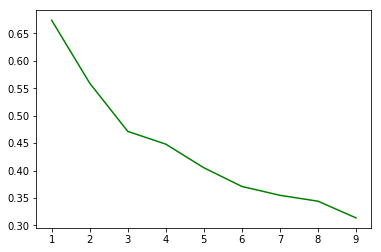

In [824]:
#Plotting the accuracy for different values of K
plt.plot(range(1,ks),mean_acc,'g')

In [825]:
#To avoid overfitting of the model we are taking K=3
#Creating the model and training it with train data
k=3
clf = KNeighborsClassifier(n_neighbors=k).fit(X_train,Y_train)
clf

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [826]:
#predicting
yhat = clf.predict(X_test)

In [827]:
#accuracy evaluation
print("Test set accuracy : ", metrics.accuracy_score(Y_test, yhat))

Test set accuracy :  0.471326164874552


<h3>14. Predicting Using the Model trained above</h3>

In [828]:
#Training the model with whole dataset
clf = KNeighborsClassifier(n_neighbors=k).fit(X,Y)
clf

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [829]:
#predicting the probable localities usnig the above trained model
pred = clf.predict(neig_df_with_sv)
print(pred)

[  4   6   5  12   5   5   5  51  65  11  11  51   6  17  11  12  85   5
   5   6  53   5   5 121   1  37   5  12   5   6  21   5   5   1  21 103
   6   5   1  51  21   5  12  52  11  22   5  40   4  74  27   5 121  12
   5  53  12  47   5]


In [830]:
#defining the function to get the keys from the values, from category_dict dictionary
def get_key(val):
    for key, value in category_dict.items():
        if value == val:
            return key
#Using the dictionary "category_dict", we'll change the indices predicted by the model back to the name of the categories
#Creating new variable "pred_cat" for predicted categories
pred_cat = []
for i in range(len(pred)):
    pred_cat.append(get_key(pred[i]))

In [840]:
#changing the list pred_cat to a dataframe
pred_cat_df = pd.DataFrame(pred_cat, columns=['Prediction'])
#adding the prediction column from pred_cat_df to neig_df_with_sv_interm
neig_df_with_sv_interm["Prediction"] = pred_cat_df["Prediction"]
#moving the locality column to the front
neig_df_with_sv_interm = neig_df_with_sv_interm[ [ 'Prediction' ] + [ col for col in neig_df_with_sv_interm.columns if col!='Prediction' ] ]
neig_df_with_sv_interm[50:55]

,Prediction,Locality,SV 1,SV 2,SV 3,SV 4,SV 5,SV 6,SV 7,SV 8,SV 9,SV 10,SV 11,SV 12,SV 13,SV 14,SV 15,SV 16,SV 17,SV 18,SV 19,SV 20,SV 21,SV 22,SV 23,SV 24,SV 25,SV 26,SV 27,SV 28,SV 29,SV 30
50,Italian Restaurant,Thubarahalli,Indian Restaurant,Creperie,Ice Cream Shop,Indian Restaurant,Indian Restaurant,Indian Restaurant,Sandwich Place,Ice Cream Shop,Dessert Shop,Restaurant,Café,Salon / Barbershop,Fast Food Restaurant,Shopping Mall,Bakery,Indian Restaurant,Pizza Place,Bookstore,Café,Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Breakfast Spot,Pizza Place,BBQ Joint,Café,Pizza Place,Café,Asian Restaurant,Sports Bar
51,Indian Restaurant,Tippasandra,Asian Restaurant,Ice Cream Shop,Pub,Multicuisine Indian Restaurant,Ice Cream Shop,Burger Joint,Indian Restaurant,Arcade,Burger Joint,Spa,Boutique,Chocolate Shop,Café,Lounge,Boutique,Ice Cream Shop,German Restaurant,Brewery,Deli / Bodega,Bakery,Ice Cream Shop,Restaurant,Ice Cream Shop,Hotel,Pub,Karnataka Restaurant,Bakery,Asian Restaurant,Vietnamese Restaurant,Café
52,Cupcake Shop,UB City,Hotel,Shopping Mall,Italian Restaurant,French Restaurant,Japanese Restaurant,Lounge,Asian Restaurant,Deli / Bodega,Furniture / Home Store,Lounge,Brewery,Clothing Store,Hotel,Italian Restaurant,Cupcake Shop,Ice Cream Shop,Burger Joint,Sushi Restaurant,Breakfast Spot,Lounge,Park,Bakery,Cocktail Bar,Ice Cream Shop,American Restaurant,Indian Restaurant,Hotel,Indian Restaurant,Indian Restaurant,Cricket Ground
53,Café,Ulsoor,Pub,Café,Café,Mexican Restaurant,Indian Restaurant,Indian Restaurant,Seafood Restaurant,Café,Brewery,Coffee Shop,Shopping Mall,Café,Hotel,Department Store,Gym / Fitness Center,Eastern European Restaurant,Boutique,Shopping Mall,Bakery,Department Store,Indian Restaurant,Hotel,Snack Place,BBQ Joint,Breakfast Spot,Cocktail Bar,Karnataka Restaurant,Indian Restaurant,Asian Restaurant,Bengali Restaurant
54,Indian Restaurant,Varthur,Italian Restaurant,Restaurant,Theater,Indian Restaurant,American Restaurant,Multiplex,Rajasthani Restaurant,Café,Restaurant,Pizza Place,Tea Room,Sandwich Place,Shopping Mall,Donut Shop,Fast Food Restaurant,Lake,Multiplex,Hotel,Pizza Place,Pizza Place,Food Court,Bakery,Indian Restaurant,Asian Restaurant,Supermarket,Motorcycle Shop,NaN,NaN,NaN,NaN


27 is coming for Thubarahalli which is a part of blue cluster which has a moderate number of italian restaurant.

<h3>10. Conclusion</h3>

<ul>
    <li>From above analysis we can infer that cluster 1(shown with red color) has almost no Italian Restaurant with the highest numbers of the same in cluster 2(shown with green color) and moderate number of Italian Restaurants are present in cluster 3(shown with blue color) located in the central part of the city.</li>
    <li>This analysis presents a great opportunity to entrepreneurs to tap into the unutilized potential of the outer parts of the city of Bangalore by opening Italian Restaurants.</li>
    <li>It is also evident that cluster 2(around the central part of the city) is suffering from high competition and over supply, hense investment in this area should be avoided by developers. </li>
    <li>Developers with unique selling propositions that can stand out from the moderate competiton in cluster 3 can take moderate risk and attract the customers already visiting the locality of this cluster because of the existing Italian Restaurant.</li>
</ul>